In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop, Adam

In [2]:
category = pd.read_csv('../data/item_categories.csv')
items = pd.read_csv('../data/items.csv')
shops = pd.read_csv('../data/shops.csv')
train = pd.read_csv('../data/sales_train_v2.csv')
test = pd.read_csv('../data/test.csv')
sample = pd.read_csv('../data/sample_submission.csv')

In [3]:
sample.head()

ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5

In [4]:
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

In [276]:
test.head(10)

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
5   5        5     5039
6   6        5     5041
7   7        5     5046
8   8        5     5319
9   9        5     5003

In [6]:
category.head(3)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2

In [7]:
items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [8]:
shops.head(3)

shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1
2               Адыгея ТЦ "Мега"        2

In [9]:
category_item = items.join(category.set_index('item_category_id'), on='item_category_id')

In [10]:
category_item.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id                    item_category_name  
0                40                            Кино - DVD  
1                76  Программы - Для дома и офиса (Цифра)  
2                40                            Кино - DVD  
3                40                            Кино - DVD  
4                40                            Кино - DVD

In [11]:
print("\t\trows\tcolumns")
print(f"Train\t\t{train.shape[0]}\t{train.shape[1]}")
print(f"Test\t\t{test.shape[0]}\t{test.shape[1]}")
print(f"Items\t\t{items.shape[0]}\t{items.shape[1]}")
print(f"Shops\t\t{shops.shape[0]}\t{shops.shape[1]}")
print(f"Category\t{category.shape[0]}\t{category.shape[1]}")

		rows	columns
Train		2935849	6
Test		214200	3
Items		22170	3
Shops		60	2
Category	84	2


In [280]:
category_item

item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id                    item_category_name  
0                    40                            Кино - DVD  
1                    76  Программы - Для дома и офиса (Цифра)  
2                    40                            Кино - DVD  
3                    40                            Кино - DVD  
4                    40                            Кино - DVD  
...                 ...                                   ...  
22165                31                       Игры PC - Цифра  
22166                54                         Книги - Цифра  
22167                49     Книги - Методические материалы 1С  
22168                62      Подарки - Гаджеты, роботы, спорт  
22169                69                    Подарки - Сувениры  

[22170 rows x 4 columns]

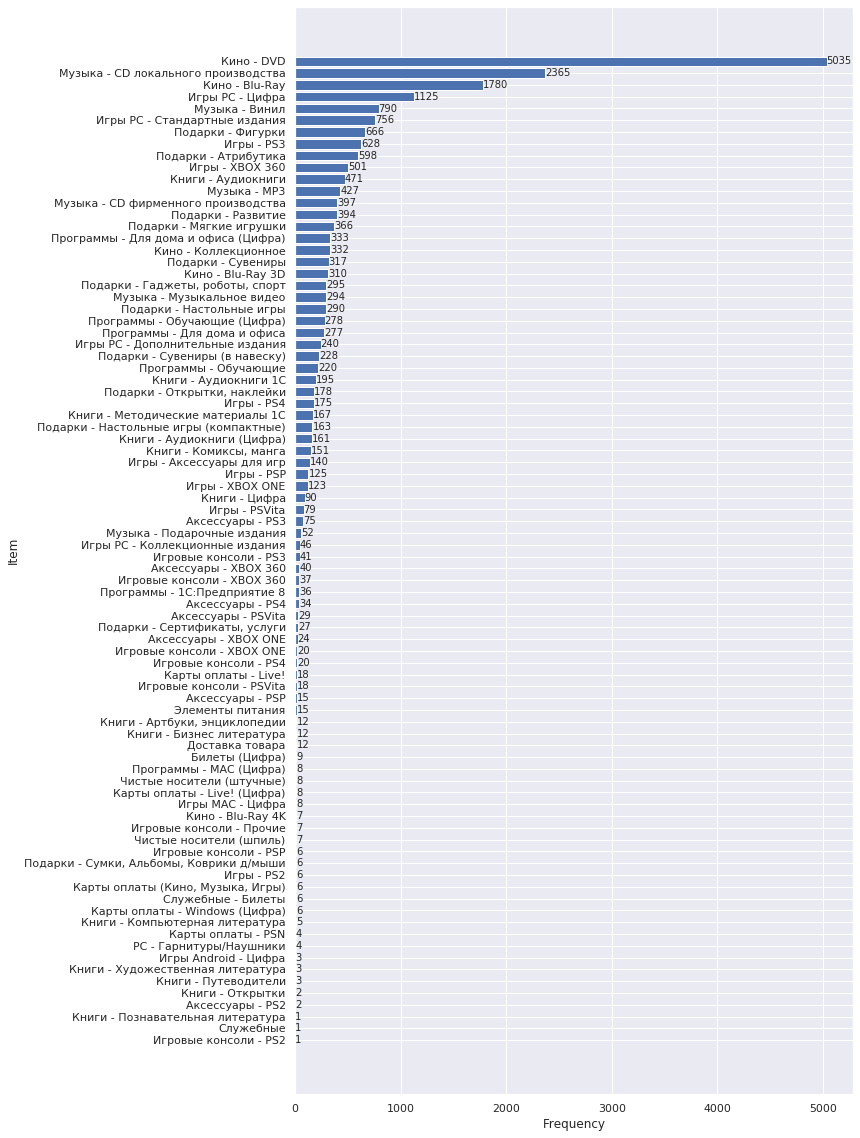

In [12]:
item_counts = category_item.item_category_name.value_counts().sort_values()
x = item_counts.index
y = item_counts.values
plt.figure(figsize=(10,20))
plt.barh(x,y)
plt.ylabel('Item')
plt.xlabel('Frequency')

for k,j in zip(x,y):
    plt.annotate(str(j), xy=(j, k), va='center')

plt.show()

In [13]:
#Ranking
cat_ranks = sorted(list(set(item_counts.values)))
print(cat_ranks)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 18, 20, 24, 27, 29, 34, 36, 37, 40, 41, 46, 52, 75, 79, 90, 123, 125, 140, 151, 161, 163, 167, 175, 178, 195, 220, 228, 240, 277, 278, 290, 294, 295, 310, 317, 332, 333, 366, 394, 397, 427, 471, 501, 598, 628, 666, 756, 790, 1125, 1780, 2365, 5035]


In [14]:
cat_rank = {}
for k,v in item_counts.items():
    cat_rank[k] = {
        'rank' : cat_ranks.index(v),
        'value' : v
    }
cat_rank

{'Игровые консоли - PS2': {'rank': 0, 'value': 1},
 'Служебные': {'rank': 0, 'value': 1},
 'Книги - Познавательная литература': {'rank': 0, 'value': 1},
 'Аксессуары - PS2': {'rank': 1, 'value': 2},
 'Книги - Открытки': {'rank': 1, 'value': 2},
 'Книги - Путеводители': {'rank': 2, 'value': 3},
 'Книги - Художественная литература': {'rank': 2, 'value': 3},
 'Игры Android - Цифра': {'rank': 2, 'value': 3},
 'PC - Гарнитуры/Наушники': {'rank': 3, 'value': 4},
 'Карты оплаты - PSN': {'rank': 3, 'value': 4},
 'Книги - Компьютерная литература': {'rank': 4, 'value': 5},
 'Карты оплаты - Windows (Цифра)': {'rank': 5, 'value': 6},
 'Служебные - Билеты': {'rank': 5, 'value': 6},
 'Карты оплаты (Кино, Музыка, Игры)': {'rank': 5, 'value': 6},
 'Игры - PS2': {'rank': 5, 'value': 6},
 'Подарки - Сумки, Альбомы, Коврики д/мыши': {'rank': 5, 'value': 6},
 'Игровые консоли - PSP': {'rank': 5, 'value': 6},
 'Чистые носители (шпиль)': {'rank': 6, 'value': 7},
 'Игровые консоли - Прочие': {'rank': 6, 'val

In [15]:
shop_item = train.join(shops.set_index('shop_id'), on='shop_id')

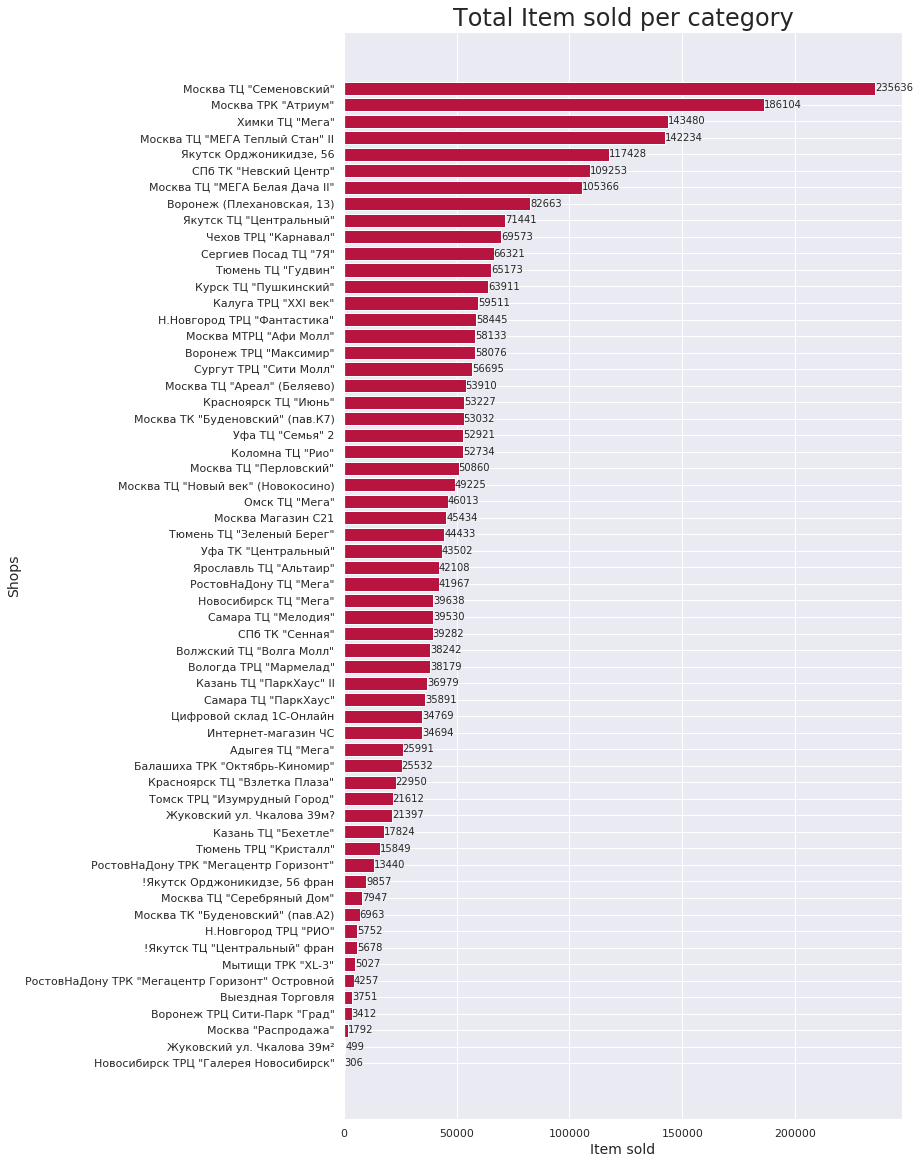

In [232]:
shop_sales = shop_item.shop_name.value_counts().sort_values()
x = shop_sales.index
y = shop_sales.values
plt.figure(figsize=(10,20))
plt.title("Total Item sold per category", fontsize=24)
plt.barh(x,y, color='#b71540')
plt.ylabel('Shops',fontsize=14)
plt.xlabel('Item sold',fontsize=14)

for k,j in zip(x,y):
    plt.annotate(str(j), xy=(j, k), va='center')

plt.show()

In [17]:
#Ranking
shop_ranks = sorted(list(set(shop_sales.values)))
print(shop_ranks)

[306, 499, 1792, 3412, 3751, 4257, 5027, 5678, 5752, 6963, 7947, 9857, 13440, 15849, 17824, 21397, 21612, 22950, 25532, 25991, 34694, 34769, 35891, 36979, 38179, 38242, 39282, 39530, 39638, 41967, 42108, 43502, 44433, 45434, 46013, 49225, 50860, 52734, 52921, 53032, 53227, 53910, 56695, 58076, 58133, 58445, 59511, 63911, 65173, 66321, 69573, 71441, 82663, 105366, 109253, 117428, 142234, 143480, 186104, 235636]


In [18]:
shop_rank = {}
for k,v in shop_sales.items():
    shop_rank[k] = {
        'rank': shop_ranks.index(v),
        'value': v
    }
shop_rank

{'Новосибирск ТРЦ "Галерея Новосибирск"': {'rank': 0, 'value': 306},
 'Жуковский ул. Чкалова 39м²': {'rank': 1, 'value': 499},
 'Москва "Распродажа"': {'rank': 2, 'value': 1792},
 'Воронеж ТРЦ Сити-Парк "Град"': {'rank': 3, 'value': 3412},
 'Выездная Торговля': {'rank': 4, 'value': 3751},
 'РостовНаДону ТРК "Мегацентр Горизонт" Островной': {'rank': 5, 'value': 4257},
 'Мытищи ТРК "XL-3"': {'rank': 6, 'value': 5027},
 '!Якутск ТЦ "Центральный" фран': {'rank': 7, 'value': 5678},
 'Н.Новгород ТРЦ "РИО"': {'rank': 8, 'value': 5752},
 'Москва ТК "Буденовский" (пав.А2)': {'rank': 9, 'value': 6963},
 'Москва ТЦ "Серебряный Дом"': {'rank': 10, 'value': 7947},
 '!Якутск Орджоникидзе, 56 фран': {'rank': 11, 'value': 9857},
 'РостовНаДону ТРК "Мегацентр Горизонт"': {'rank': 12, 'value': 13440},
 'Тюмень ТРЦ "Кристалл"': {'rank': 13, 'value': 15849},
 'Казань ТЦ "Бехетле"': {'rank': 14, 'value': 17824},
 'Жуковский ул. Чкалова 39м?': {'rank': 15, 'value': 21397},
 'Томск ТРЦ "Изумрудный Город"': {

In [19]:
train_df = train\
            .join(shops.set_index('shop_id'), on='shop_id')\
            .join(category_item.set_index('item_id'), on='item_id')

In [22]:
def feature_transform(row):
    row['month_year'] = datetime.strptime(row['date'], "%d.%m.%Y").date().strftime("%B-%Y")
    row['category_rank'] = cat_rank[row['item_category_name']]['rank']
    row['shop_rank'] = shop_rank[row['shop_name']]['rank']
    return row
train_df = train_df.apply(feature_transform, axis=1)

In [23]:
train_df.head(5)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

                shop_name                                 item_name  \
0  Ярославль ТЦ "Альтаир"                         ЯВЛЕНИЕ 2012 (BD)   
1     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP   
2     Москва ТРК "Атриум"  DEEP PURPLE  The House Of Blue Light  LP   
3     Москва ТРК "Атриум"  DEEP PURPLE  Who Do You Think We Are  LP   
4     Москва ТРК "Атриум"   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)   

   item_category_id                   item_category_name    month_year  \
0                37                       Кино - Blu-Ray  January-2013   
1                58                       Музыка - Винил  January-2013   
2                58                       Музыка - Винил  January-2013   
3                58                       Музыка - Винил  January-2013   
4                56  Музыка - CD фирменного производства  January-2013   

   category_rank  shop_rank  
0             60         30  
1             58         58  
2             58         58  
3             58         58  
4             50         58

In [288]:
spm = train.groupby("date_block_num")['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day':'item_cnt_month'})

In [294]:
xlabels = train_df.month_year.unique()
x = spm['date_block_num'].values
y = spm['item_cnt_month'].astype(int).values

In [155]:
mask2013 = ['2013' in month for month in xlabels]
mask2014 = ['2014' in month for month in xlabels]
mask2015 = ['2015' in month for month in xlabels]


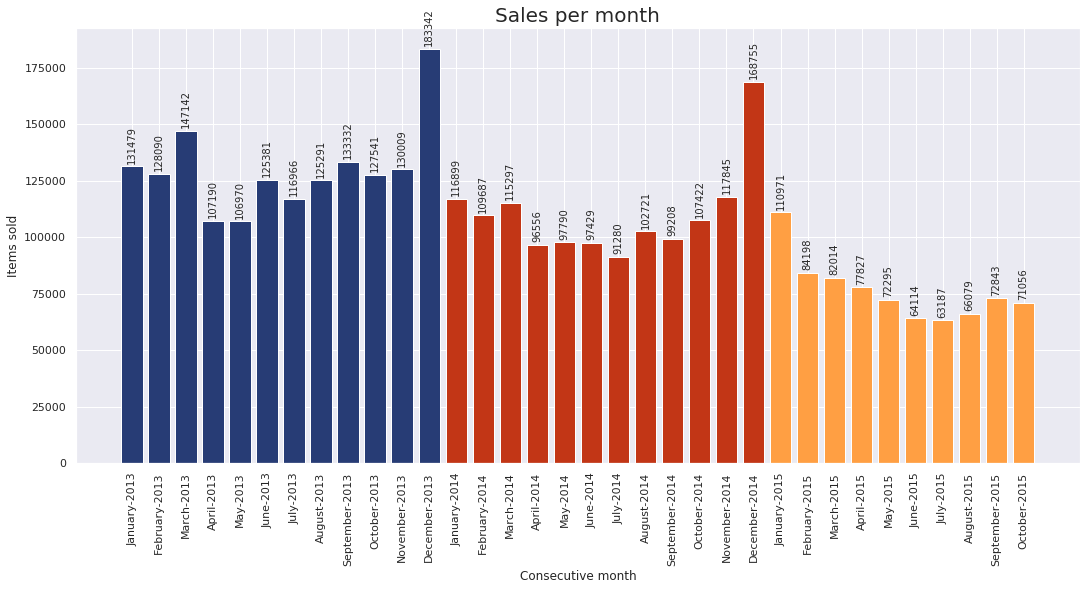

In [295]:
plt.figure(figsize=(18,8))
plt.title('Sales per month',fontsize=20)
plt.bar(x[mask2013], y[mask2013], color='#273c75')
plt.bar(x[mask2014], y[mask2014], color='#c23616')
plt.bar(x[mask2015], y[mask2015], color='#ff9f43')
plt.xticks(x,xlabels,rotation=90)
plt.xlabel('Consecutive month')
plt.ylabel('Items sold')



for k,j in zip(x,y):
    plt.annotate(str(j), xy=(k,j+ 2000), ha='center', rotation=90)
plt.show()

In [303]:
#pattern for each category
cat_by_month = train_df.groupby(['item_category_name','date_block_num'])["item_cnt_day"].sum().reset_index(name="item_cnt_month")
cat_by_month["item_cnt_month"] = cat_by_month["item_cnt_month"].astype(int)

In [320]:
#because when we aggregate the plot, when want the range to be close. Hence, the sorting
sorted_category = cat_by_month.groupby(['item_category_name'])['item_cnt_month'].sum().sort_values().reset_index(name="item_cnt_total")

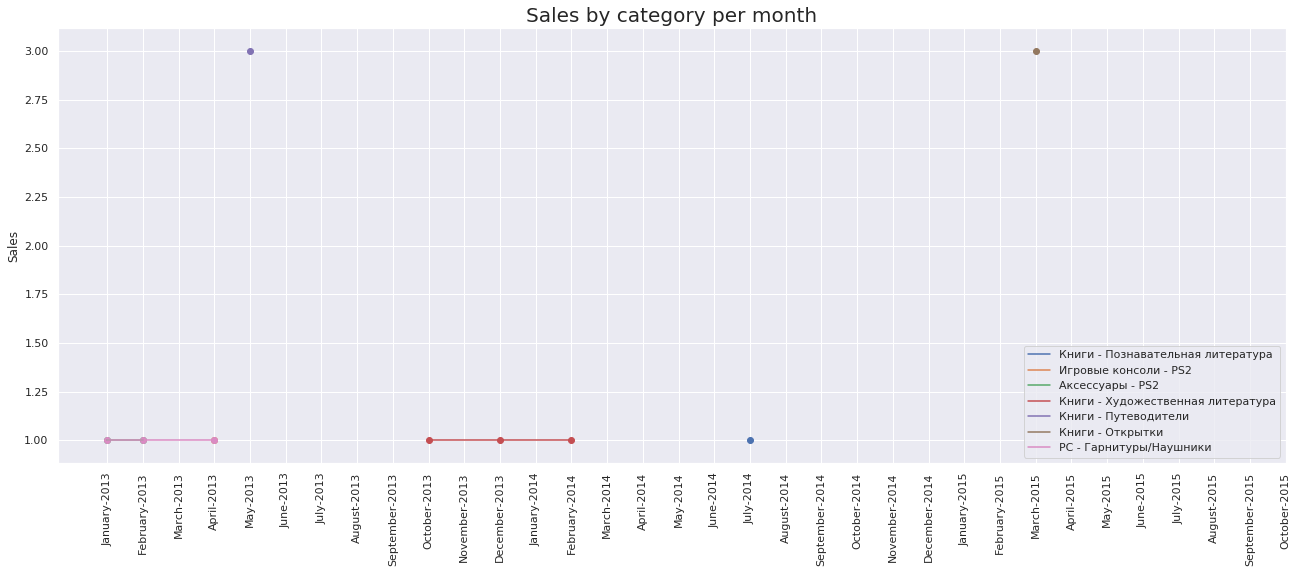

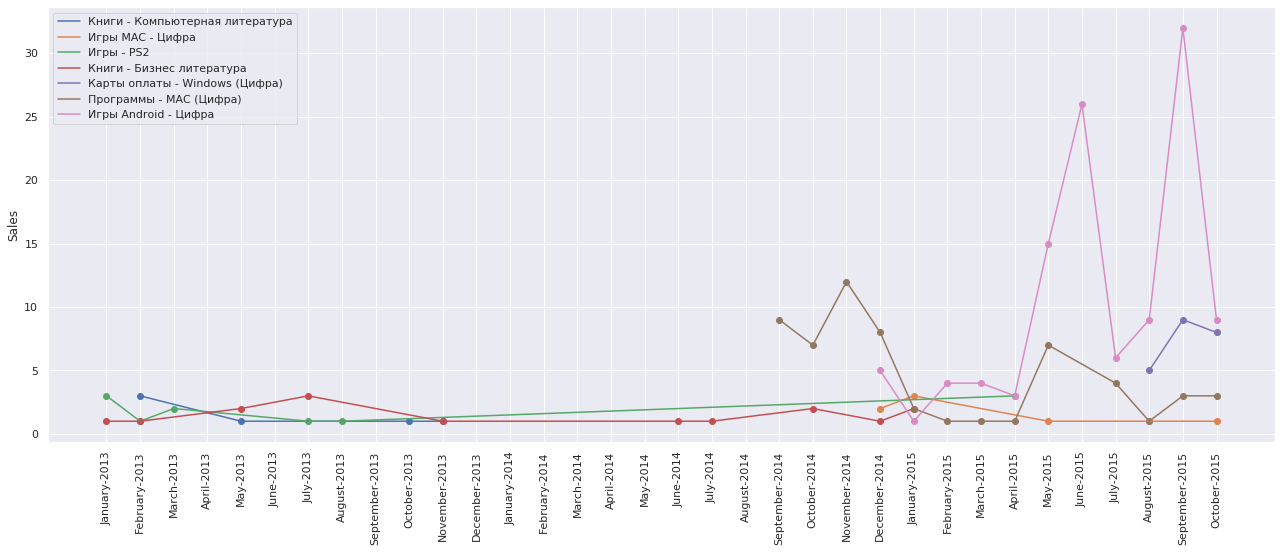

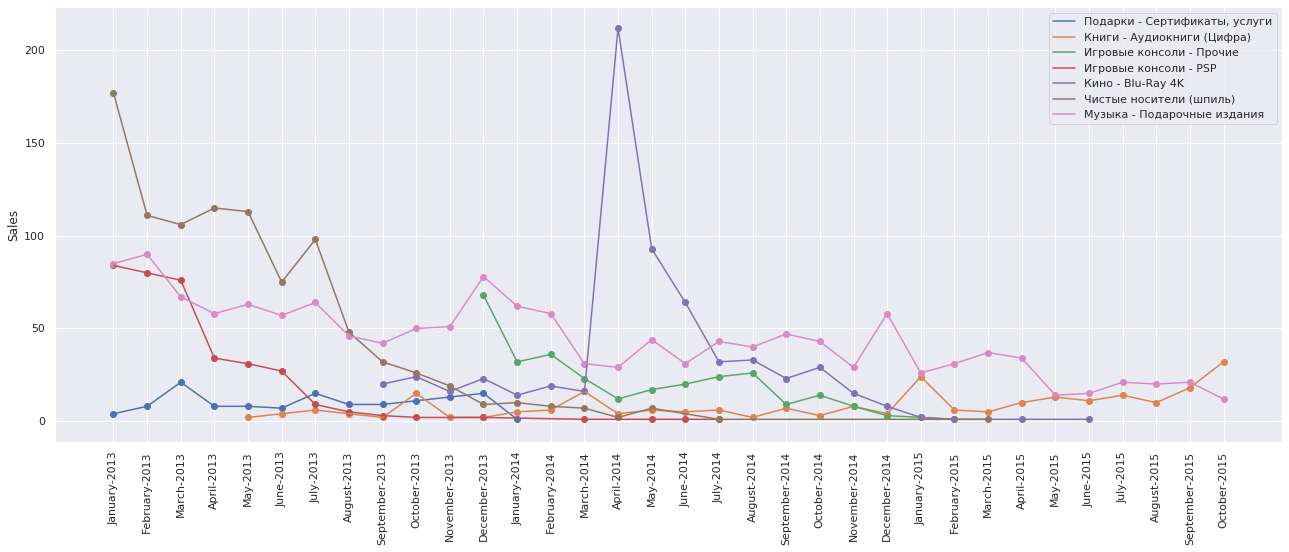

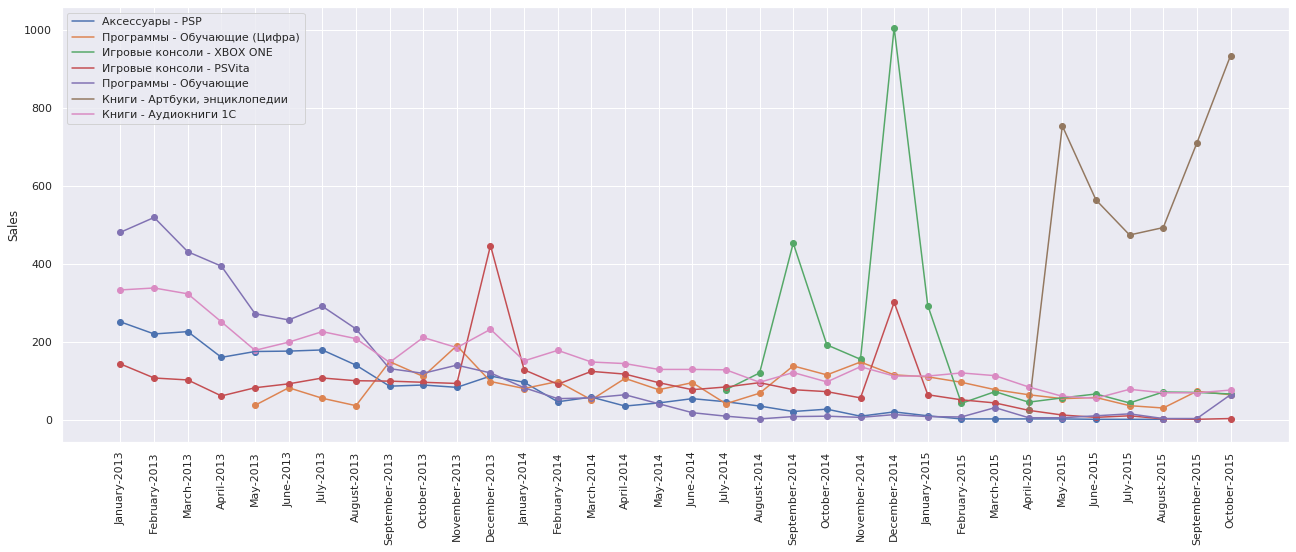

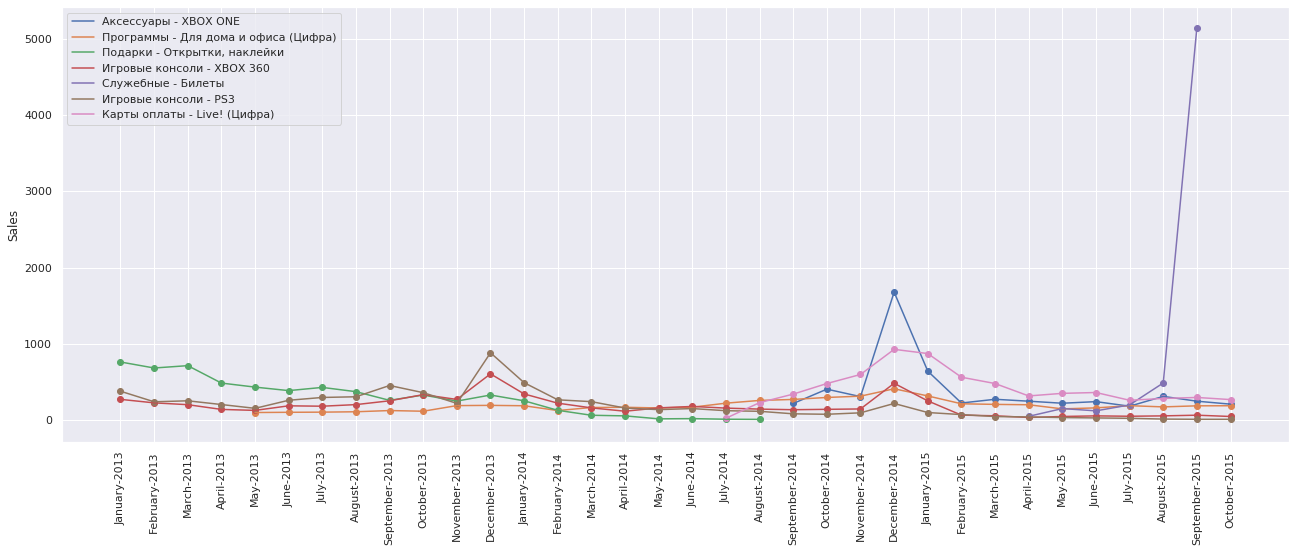

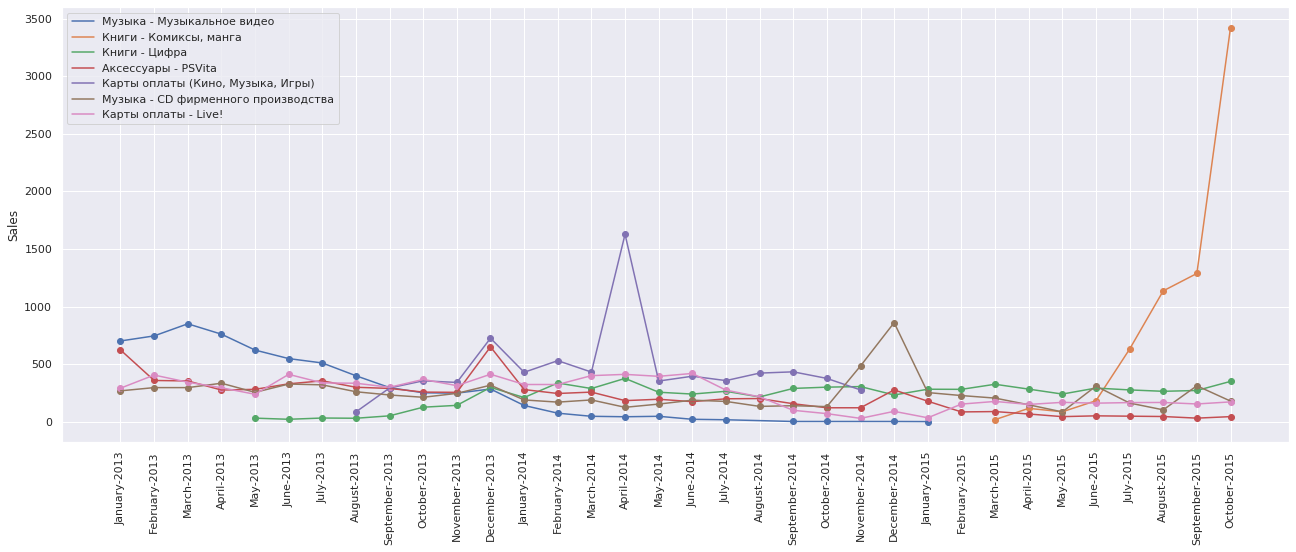

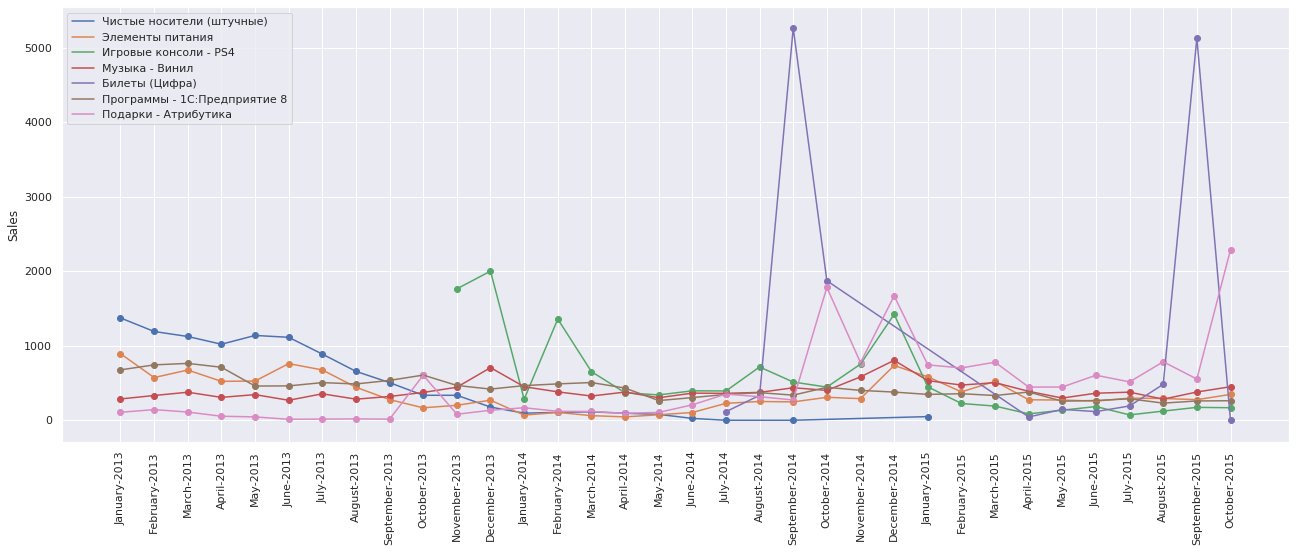

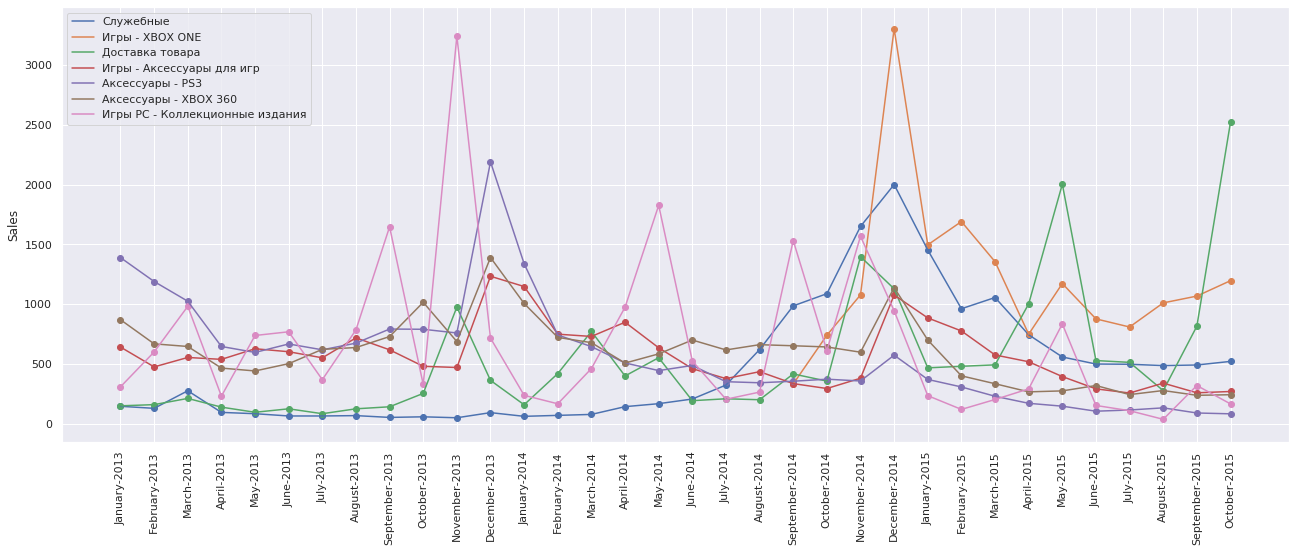

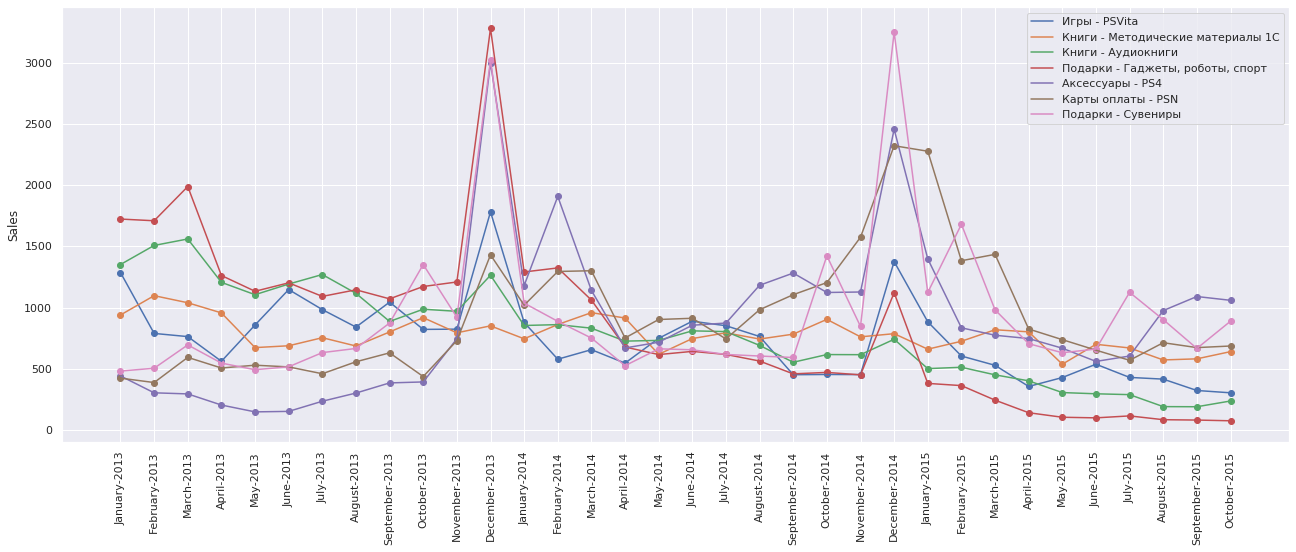

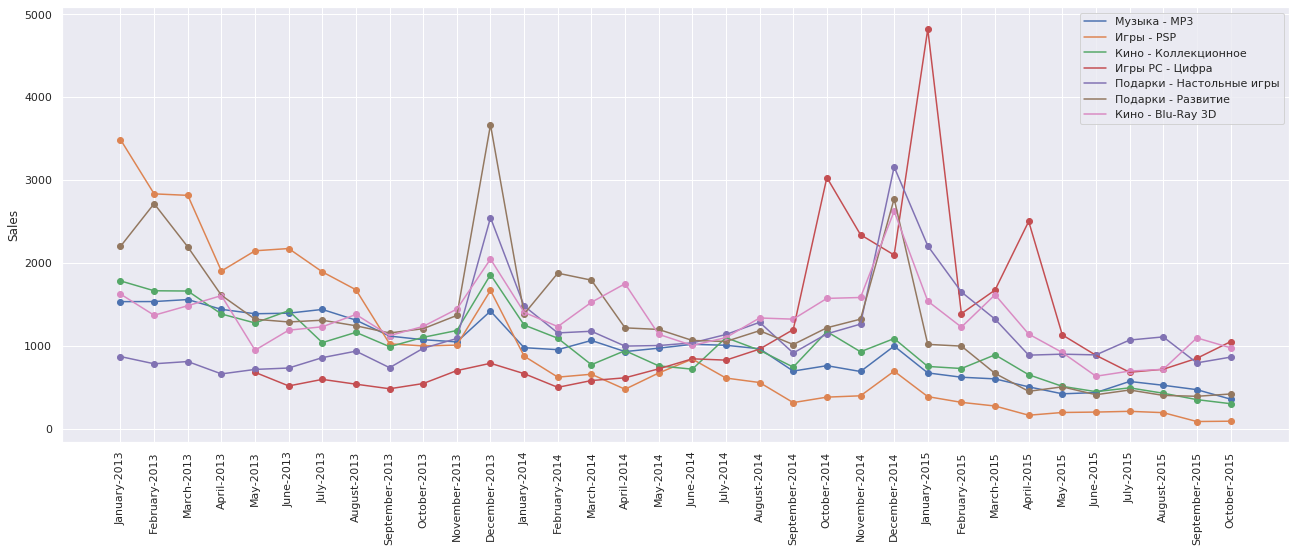

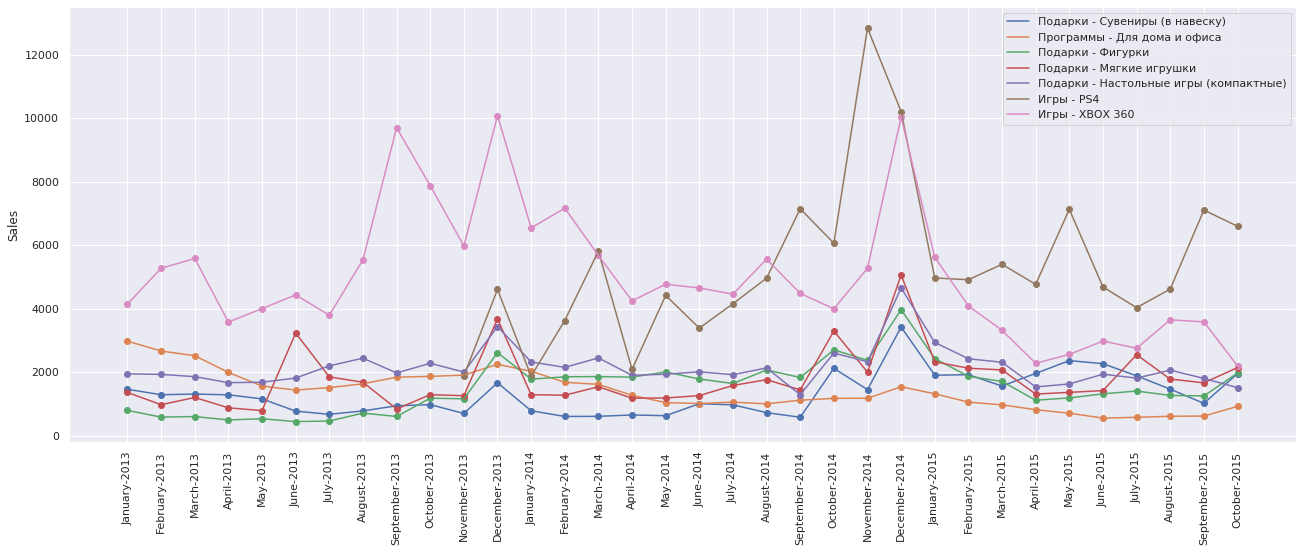

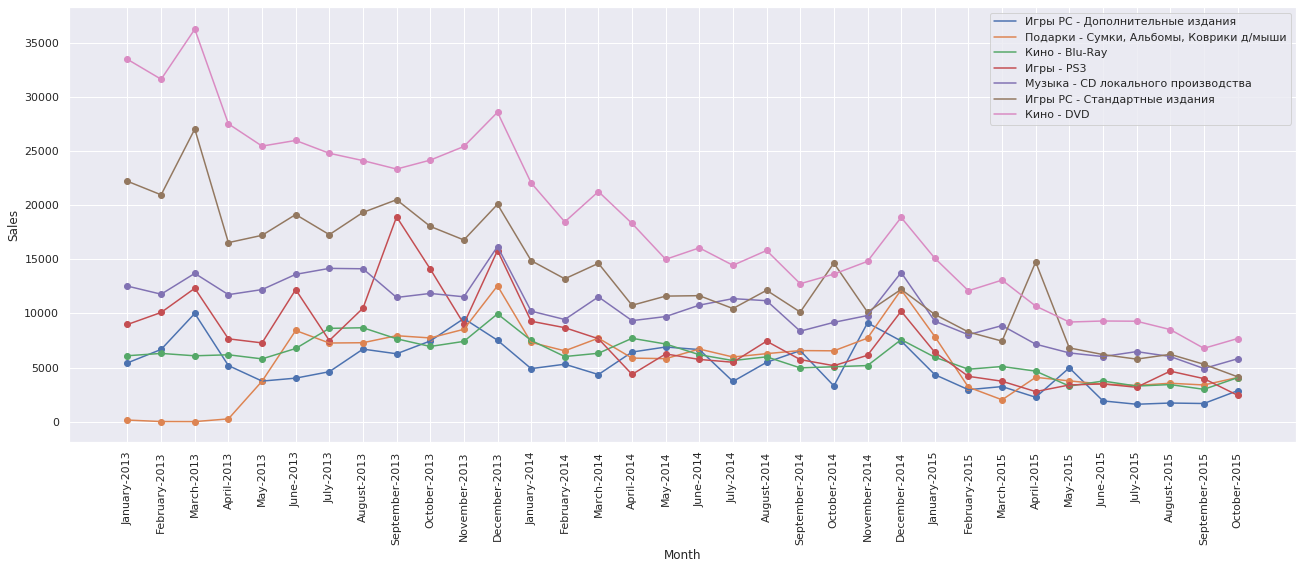

In [306]:
plt.figure(figsize=(22,8))
plt.title('Sales by category per month',fontsize=20)
max_category = 7
count = 0
for i,item in enumerate(sorted_category.item_category_name.unique()):
    if count == max_category:
        count = 0
        plt.xticks(np.arange(0,34),xlabels, rotation=90)
        plt.legend()   
        plt.figure(figsize=(22,8))
        
    plot_df = cat_by_month[cat_by_month.item_category_name == item].sort_values('date_block_num')
    x = plot_df.date_block_num.values
    y = plot_df.item_cnt_month.values
    
    plt.ylabel('Sales')
    plt.scatter(x,y)
    plt.plot(x,y,label=item)
    count = count + 1

plt.xlabel('Month')
plt.legend()    
plt.xticks(np.arange(0,34),xlabels, rotation=90)
plt.show()

/home/mars/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


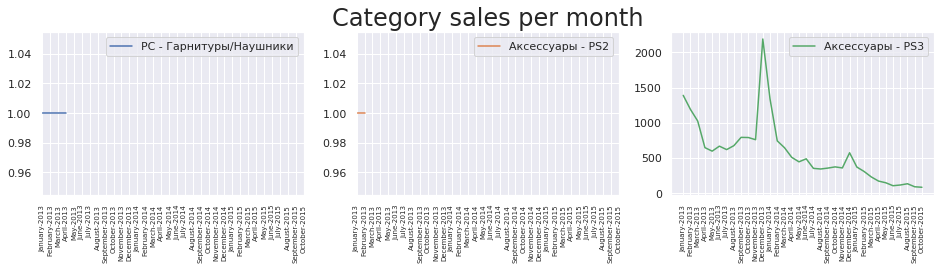

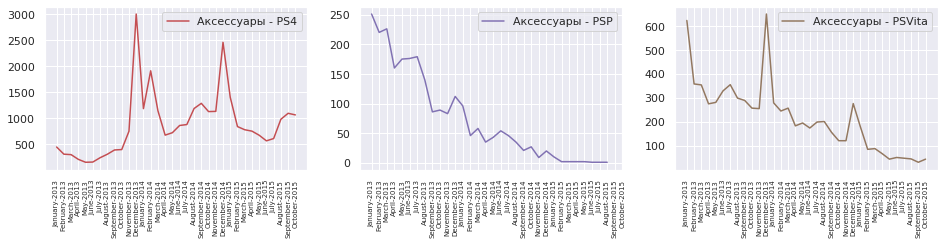

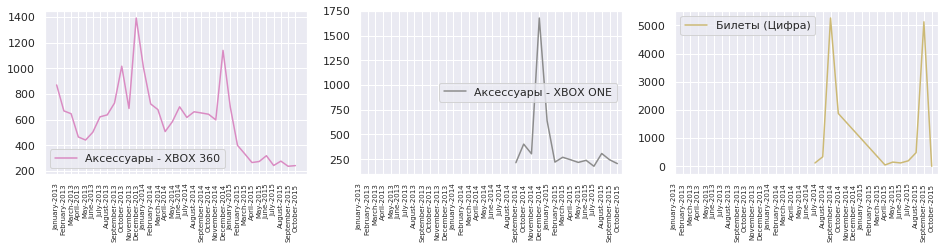

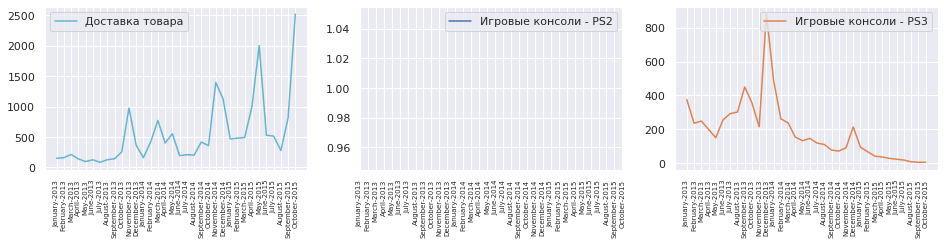

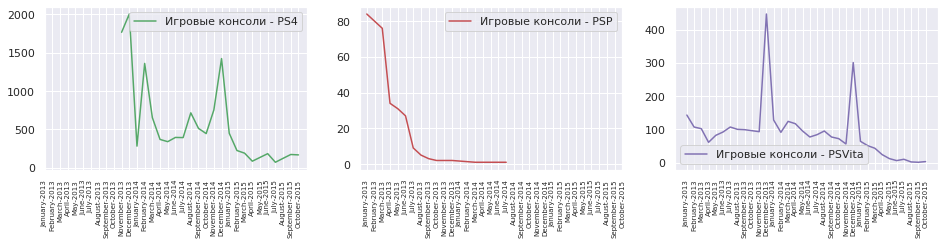

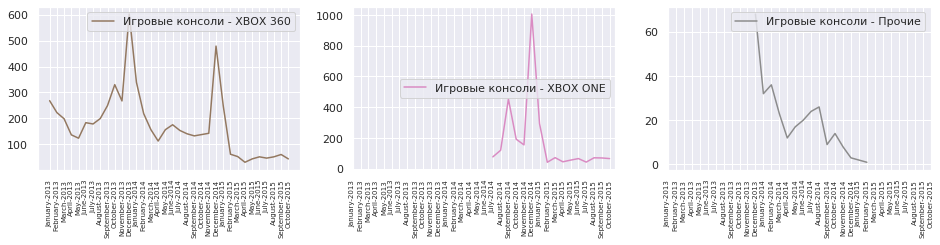

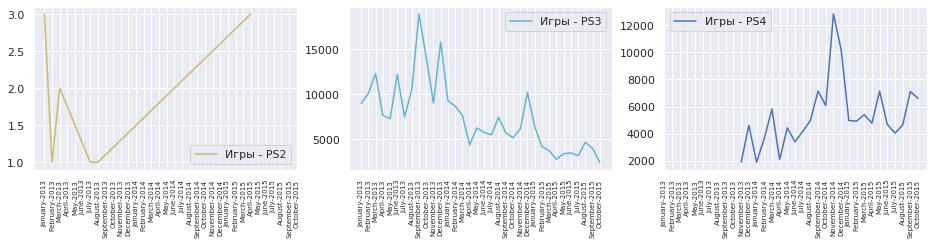

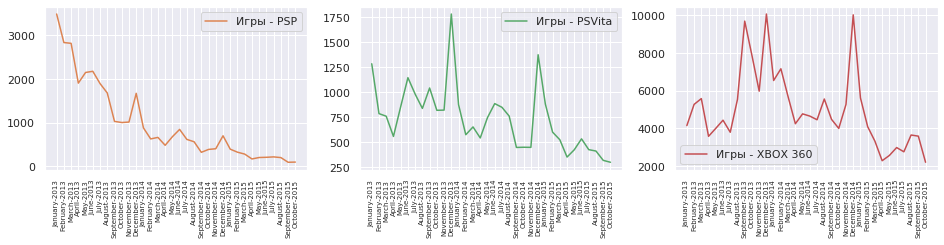

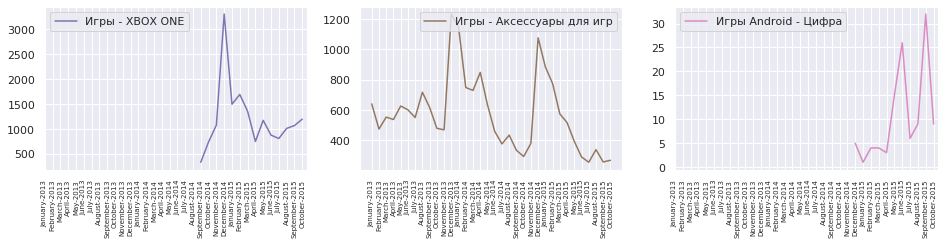

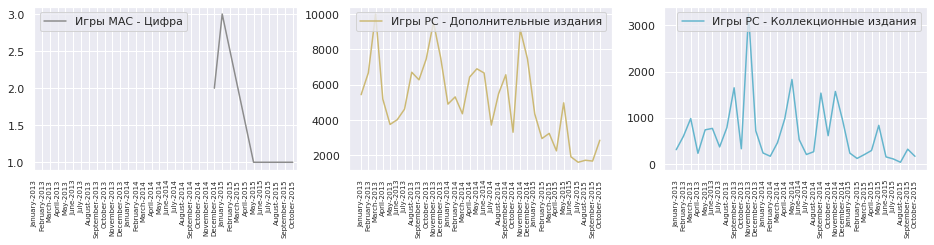

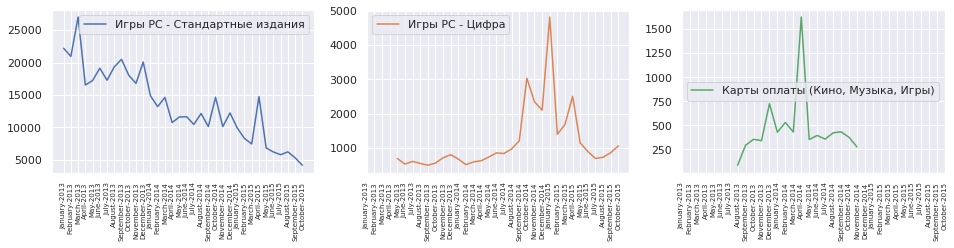

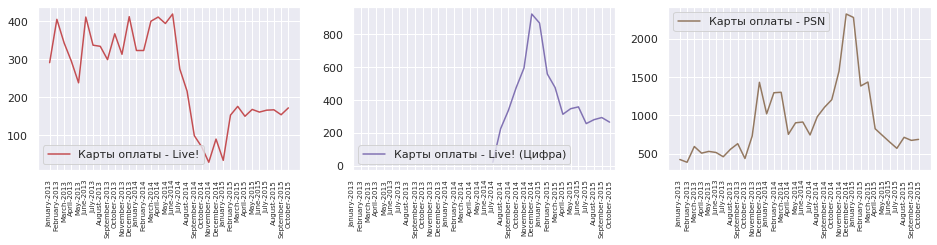

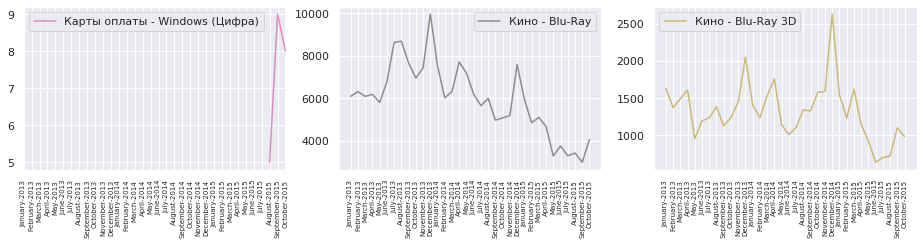

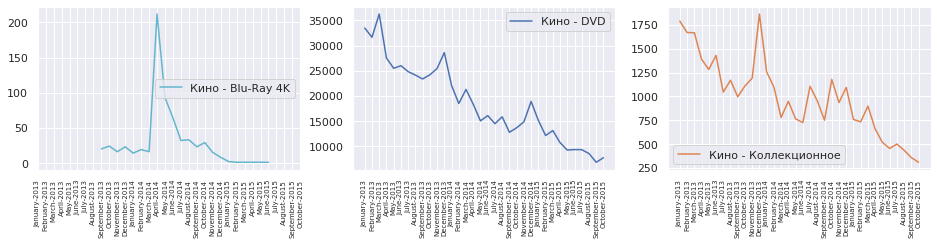

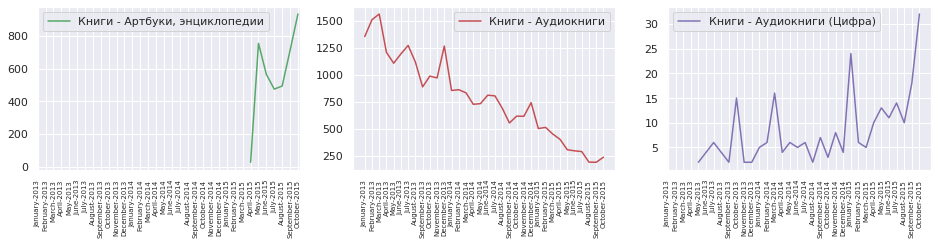

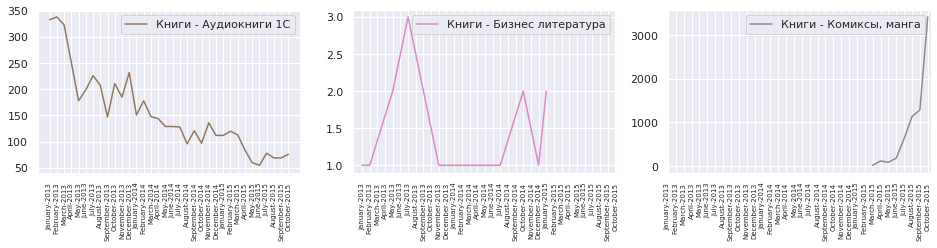

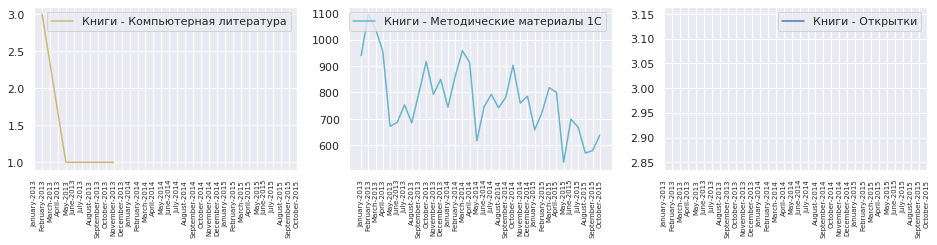

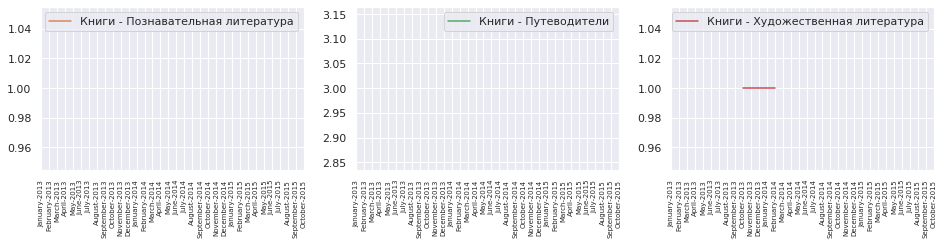

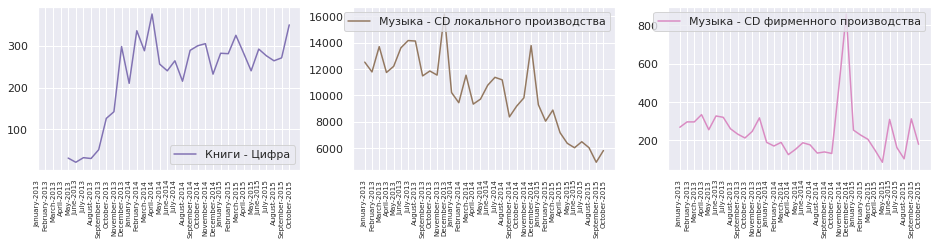

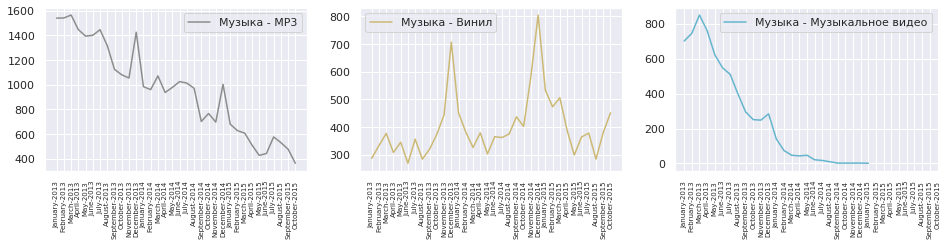

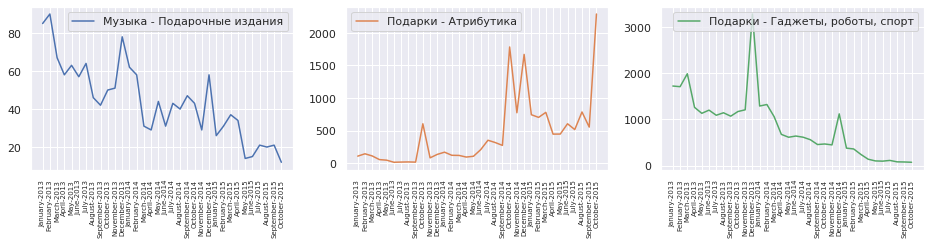

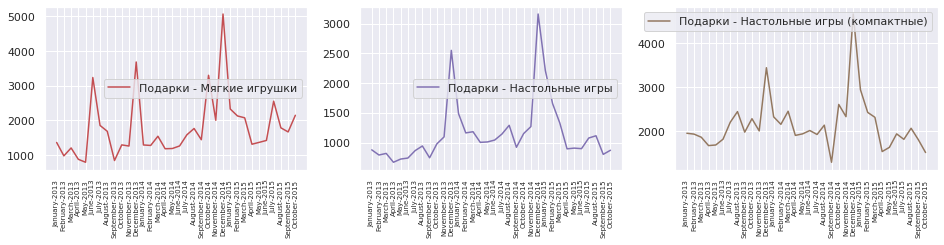

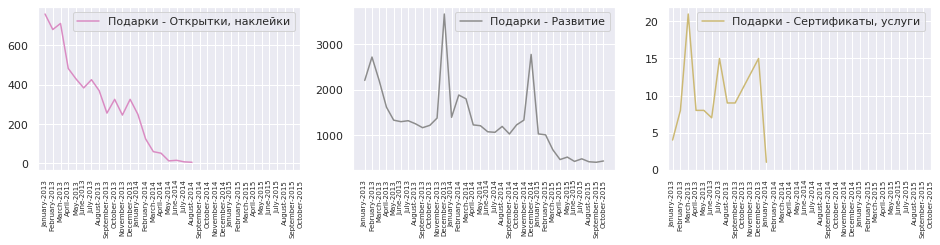

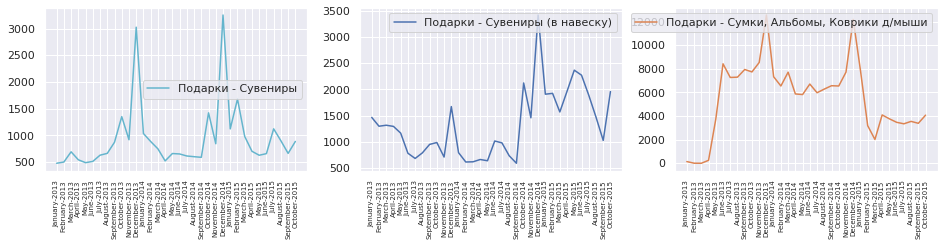

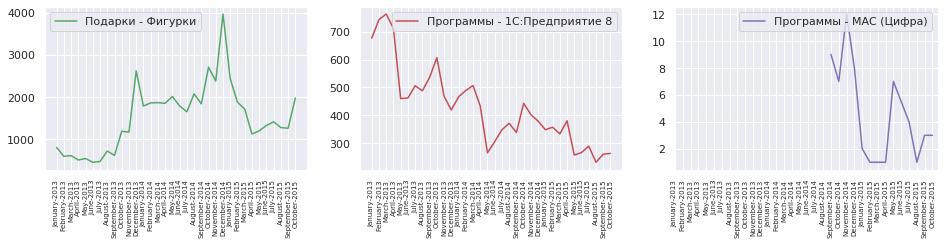

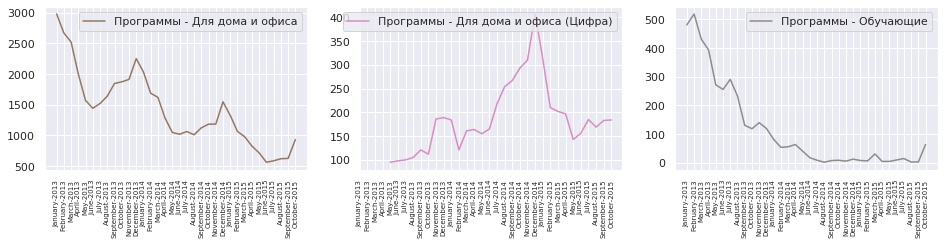

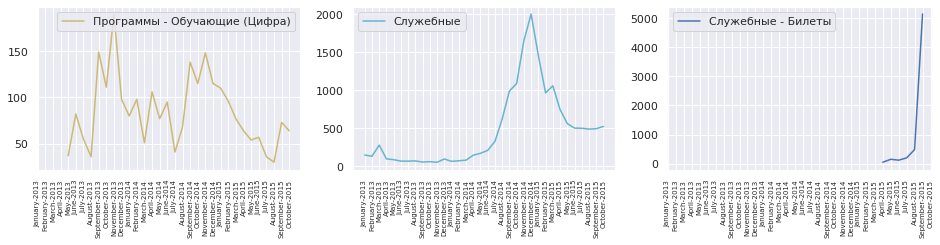

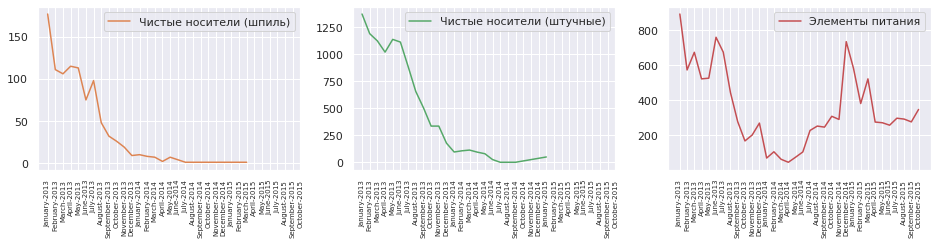

In [307]:
f = plt.figure(figsize=(16,3))
plot_index = 1

plt.subplot(132).set_title('Category sales per month',fontsize=24)
for i,item in enumerate(cat_by_month.item_category_name.unique()):
    if plot_index == 4:
        plot_index = 1   
        plt.show()
        f = plt.figure(figsize=(16,3))
        
    ax = f.add_subplot(1,3,plot_index)
    plot_df = cat_by_month[cat_by_month.item_category_name == item]
    ax.plot(plot_df.date_block_num.values,
             plot_df.item_cnt_month.values,
             label=item,
             color='C'+str(i))
    ax.set_xticks(np.arange(0,34))
    ax.set_xticklabels(xlabels, fontsize=7)
    
    ax.legend()
    
    plot_index = plot_index + 1
    plt.setp(ax.get_xticklabels(), rotation=90)
    

plt.show()

In [309]:
#pattern for each shop
shop_by_month = train_df.groupby(['shop_name','date_block_num'])["item_cnt_day"].sum().reset_index(name="item_cnt_month")

In [317]:
sorted_shop = shop_by_month.groupby(['shop_name'])['item_cnt_month'].sum().sort_values().reset_index(name="item_cnt_total")

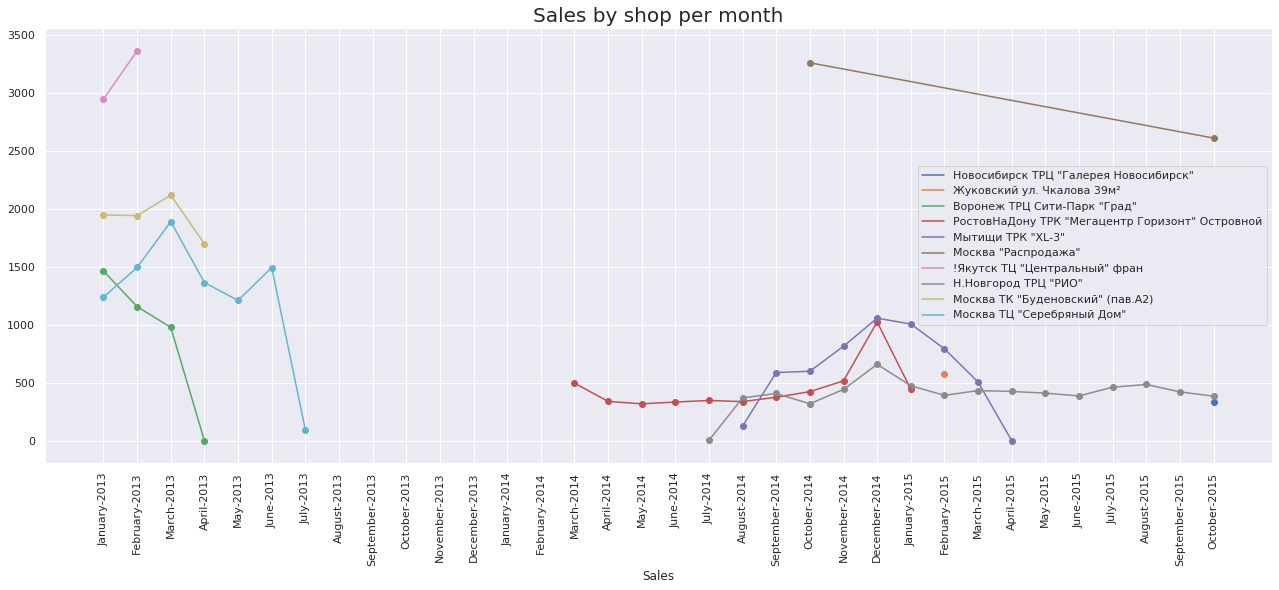

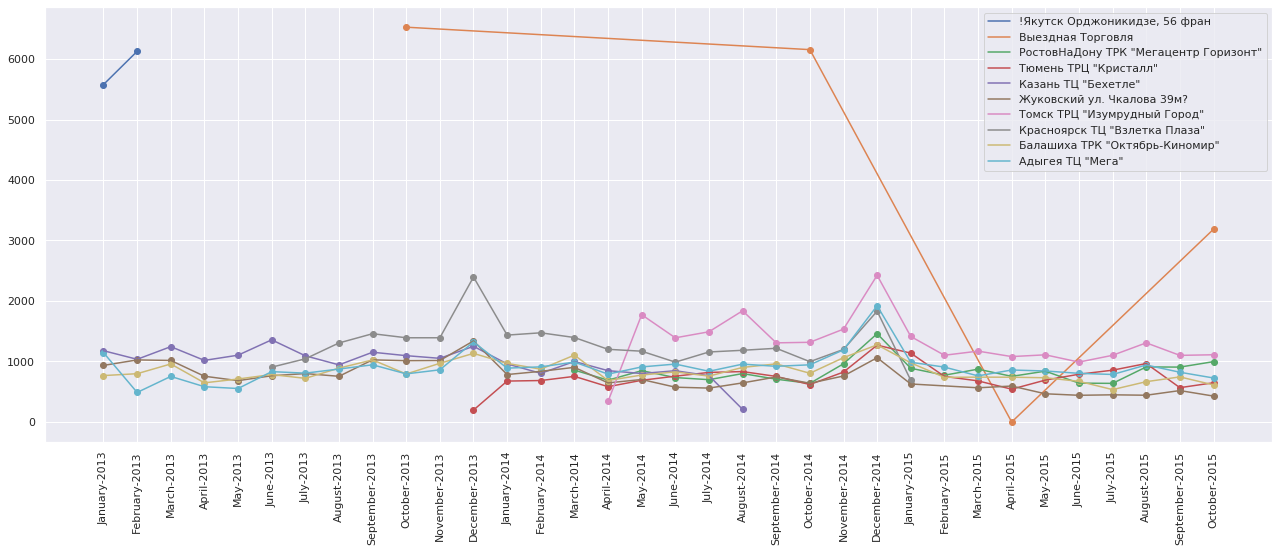

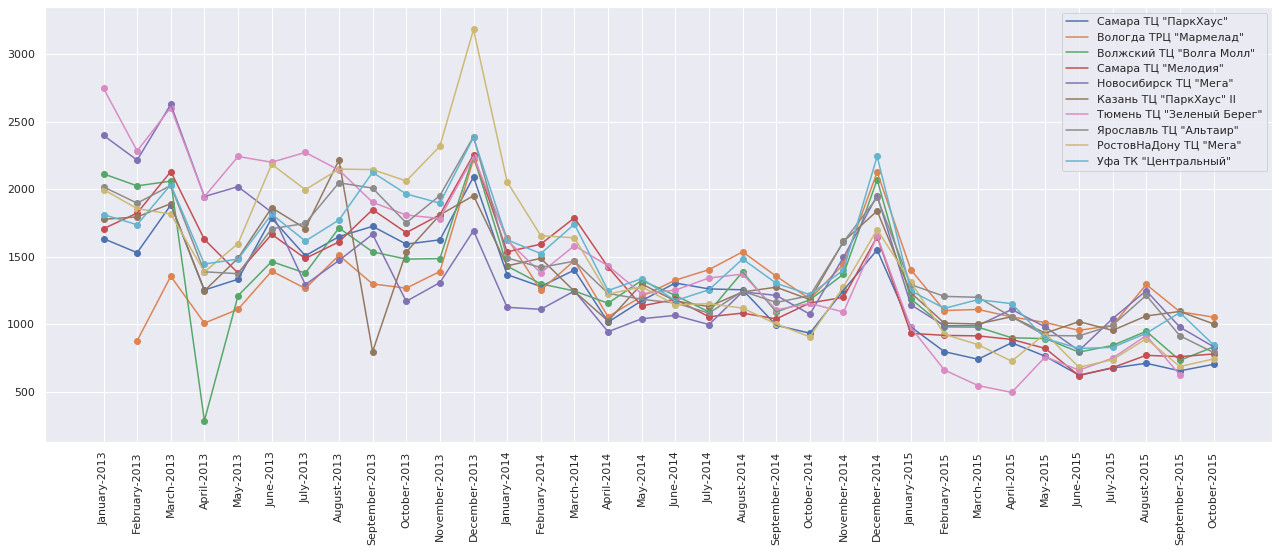

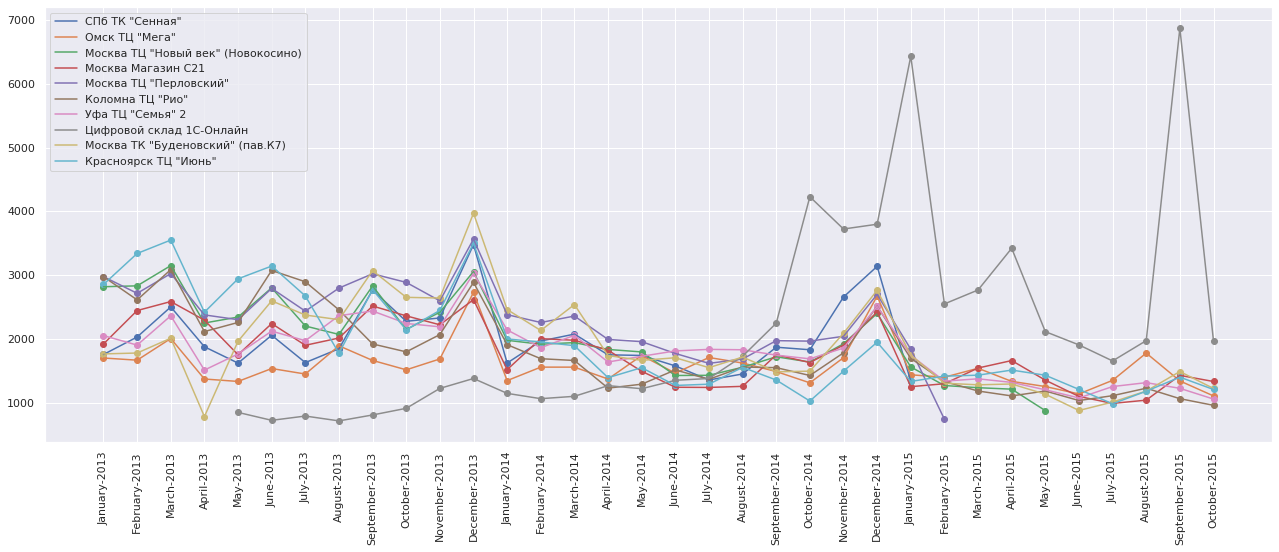

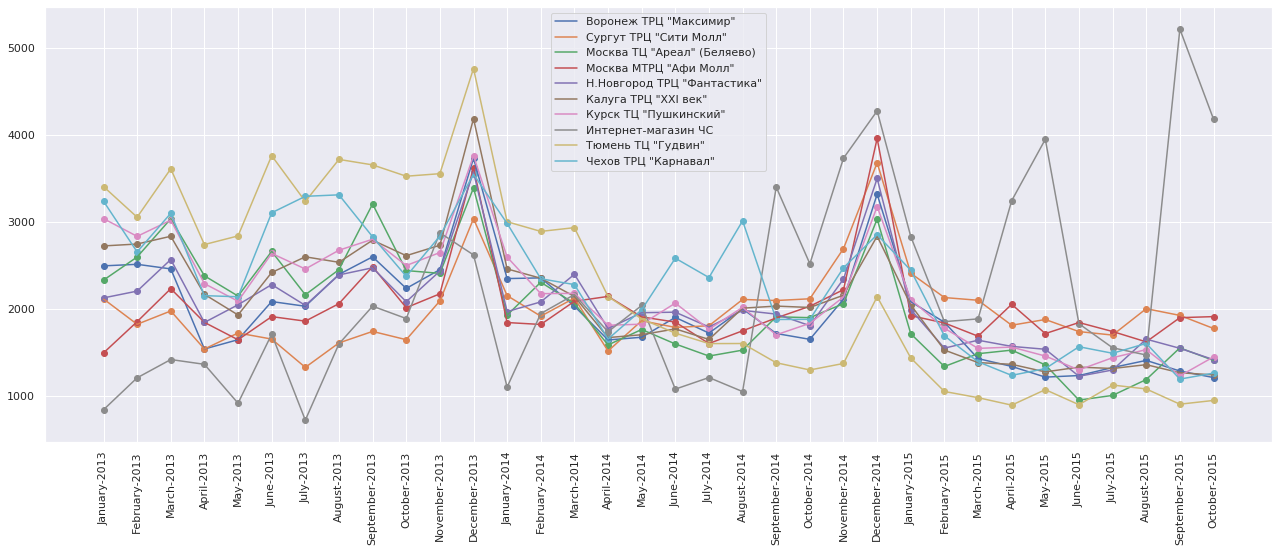

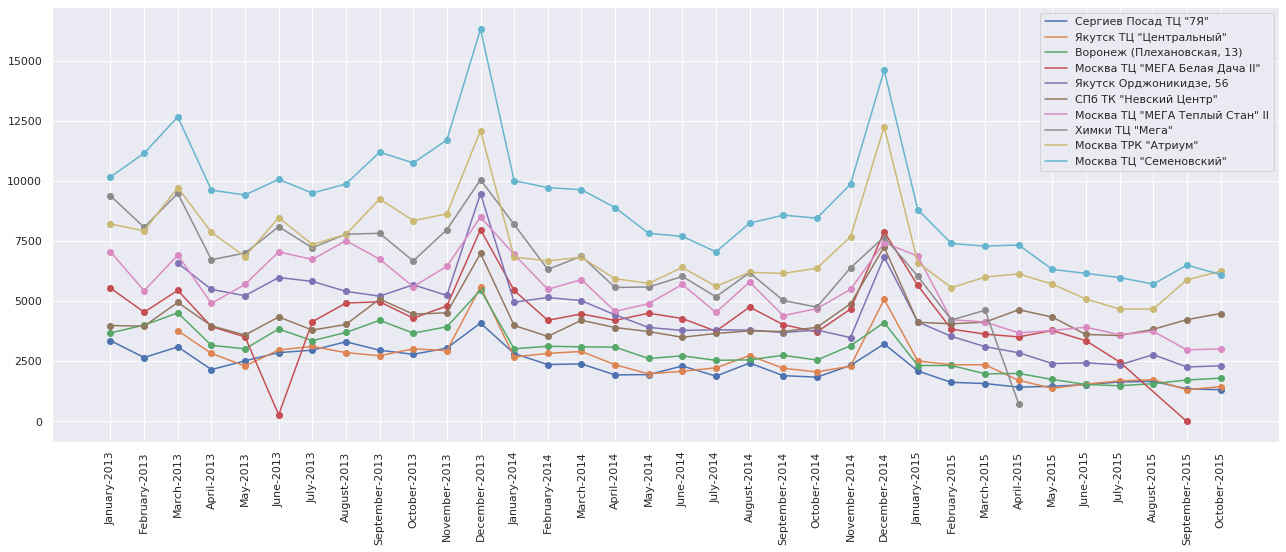

In [318]:
plt.figure(figsize=(22,8))
plt.title('Sales by shop per month',fontsize=20)
plt.xlabel('Month')
plt.xlabel('Sales')

max_shop = 10
count = 0
for i,item in enumerate(sorted_shop.shop_name.unique()):
    if count == max_shop:
        plt.xticks(np.arange(0,34),xlabels, rotation=90)
        plt.legend()
        plt.show()
        plt.figure(figsize=(22,8))
        count = 0
    plot_df = shop_by_month[shop_by_month.shop_name == item]
    x = plot_df.date_block_num.values
    y= plot_df.item_cnt_month.values
    plt.scatter(x,
             y)
    plt.plot(x,
             y,
             label=item)
    count = count + 1

plt.xticks(np.arange(0,34),xlabels, rotation=90)
plt.legend()    
plt.show()

/home/mars/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


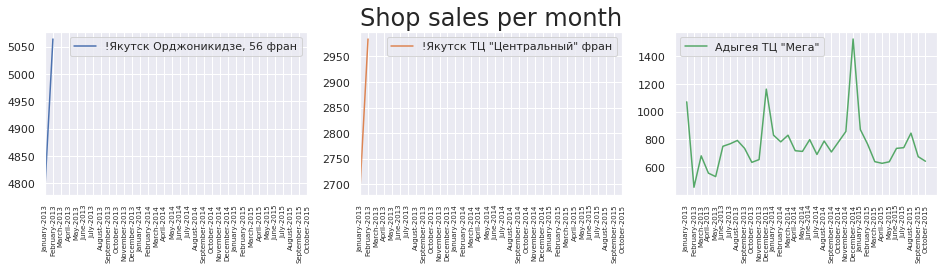

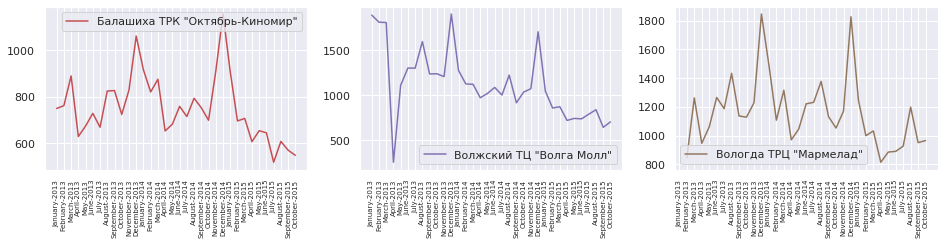

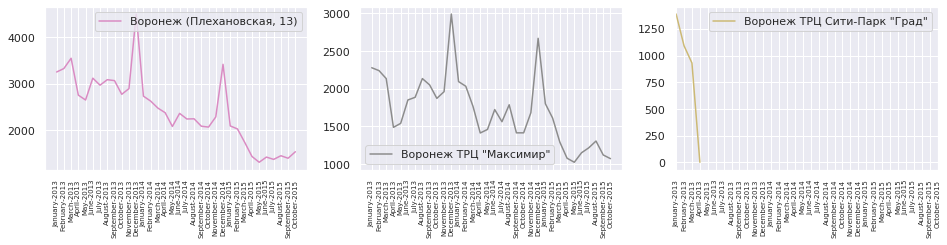

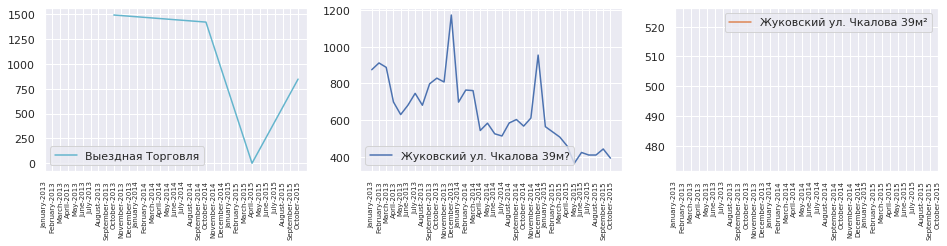

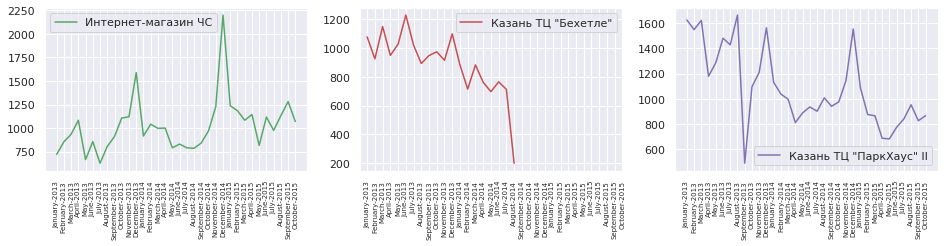

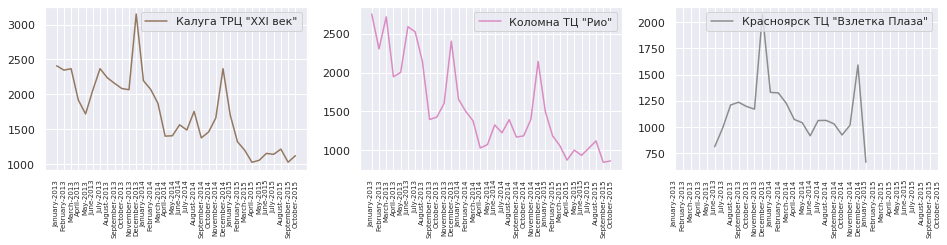

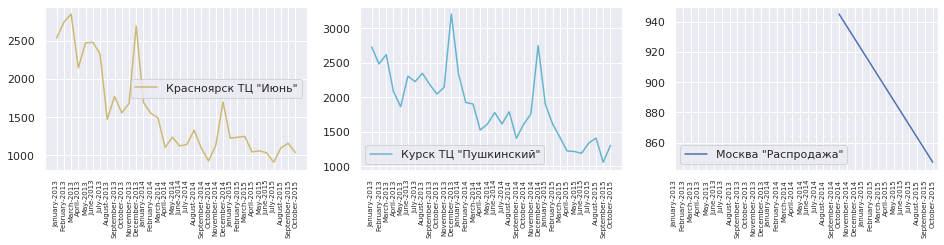

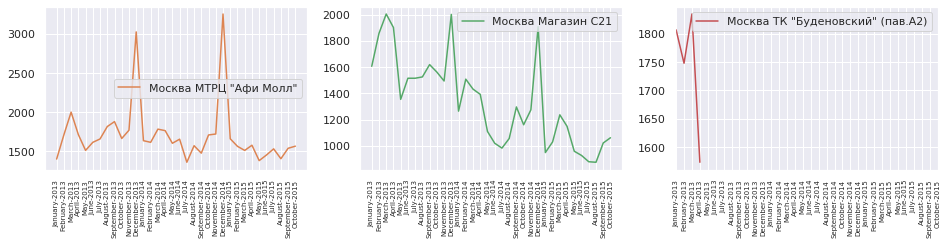

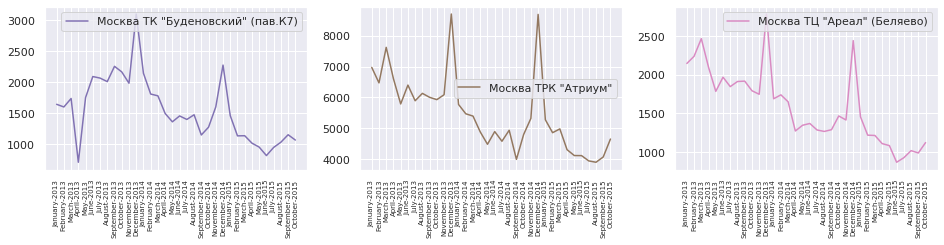

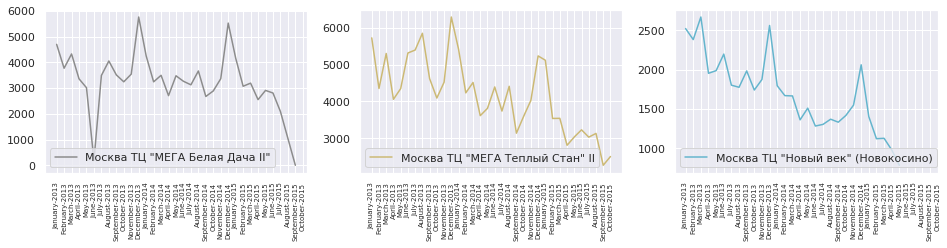

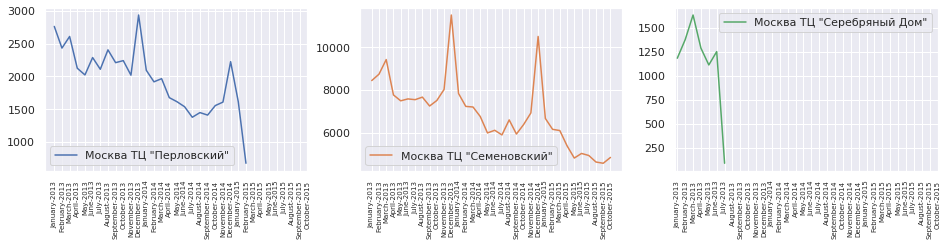

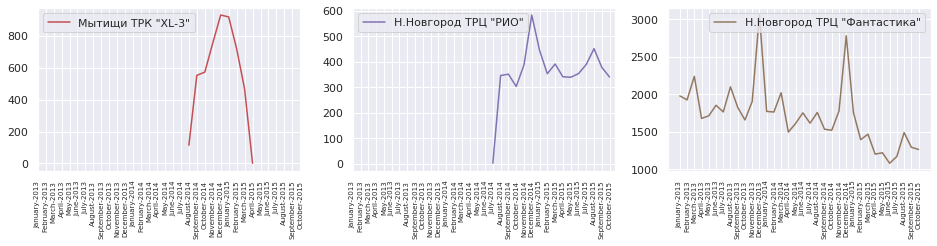

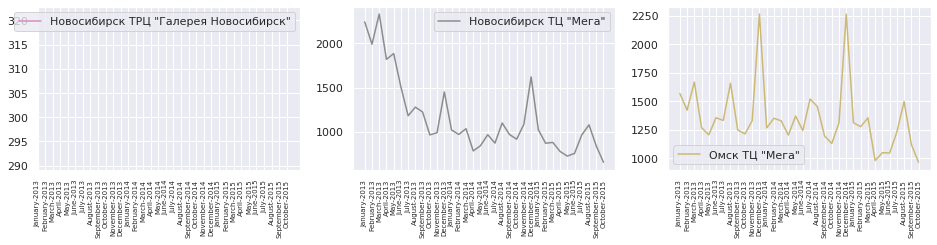

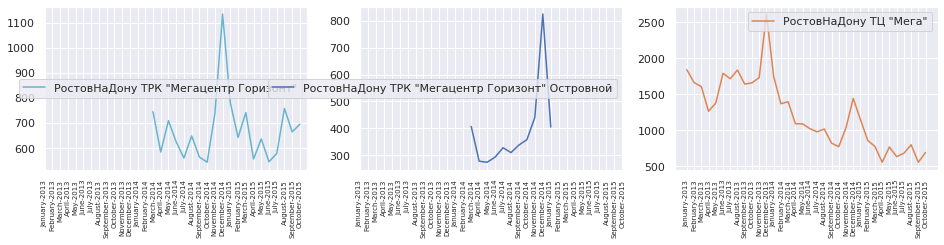

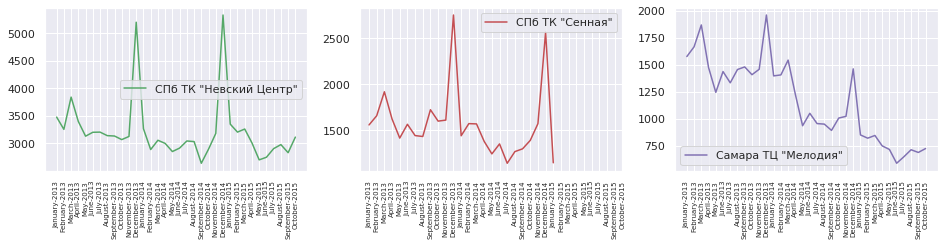

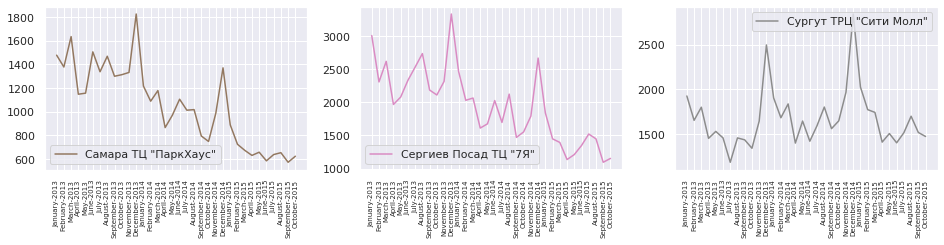

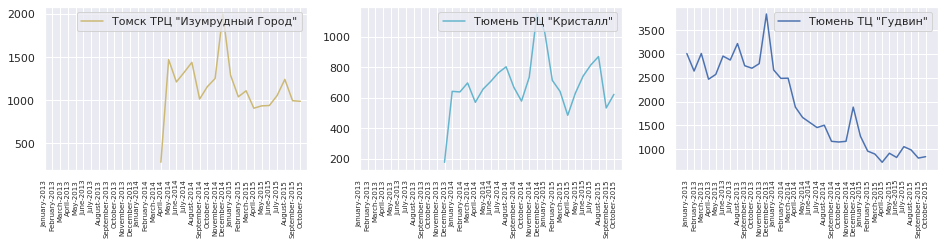

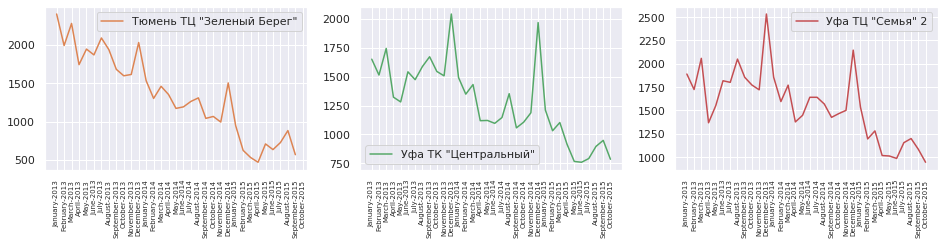

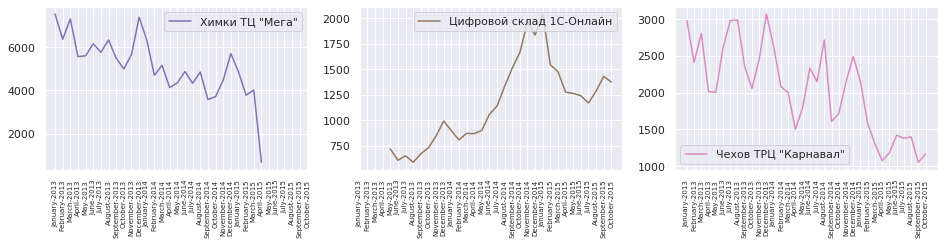

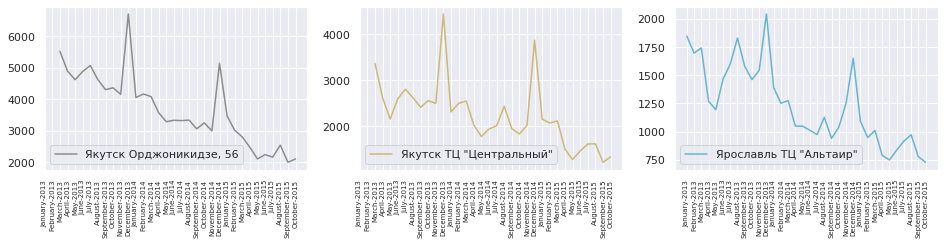

In [201]:
#Deeper view

f = plt.figure(figsize=(16,3))
plot_index = 1

plt.subplot(132).set_title('Shop sales per month',fontsize=24)
for i,item in enumerate(shop_by_month.shop_name.unique()):
    if plot_index == 4:
        plot_index = 1   
        plt.show()
        f = plt.figure(figsize=(16,3))
        
    ax = f.add_subplot(1,3,plot_index)
    plot_df = shop_by_month[shop_by_month.shop_name == item]
    ax.plot(plot_df.date_block_num.values,
             plot_df.total_count.values,
             label=item,
             color='C'+str(i))
    ax.set_xticks(np.arange(0,34))
    ax.set_xticklabels(xlabels, fontsize=7)
    
    ax.legend()
    
    plot_index = plot_index + 1
    plt.setp(ax.get_xticklabels(), rotation=90)
    

plt.show()

## Data Engineering

Now, we will prepare the data to be in a form where it can fit into a model.

based on competition description

"We are asking you to predict total sales for every product and store in the **next month**. By solving this competition you will be able to apply and enhance your data science skills."

So, since we are predicting the next month we should shift the target for each instances

In [330]:
#preparing data for modelling
train_df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_name', 'item_name', 'item_category_id',
       'item_category_name', 'month_year', 'category_rank', 'shop_rank'],
      dtype='object')

In [357]:
aggregated_train = train_df.groupby(['date_block_num','shop_id','item_id'])["item_cnt_day"].sum().reset_index(name="item_cnt_month")
aggregated_train['target'] = aggregated_train['item_cnt_month'].shift(1)
aggregated_train

date_block_num  shop_id  item_id  item_cnt_month  target
0                     0        0       32             6.0     NaN
1                     0        0       33             3.0     6.0
2                     0        0       35             1.0     3.0
3                     0        0       43             1.0     1.0
4                     0        0       51             2.0     1.0
...                 ...      ...      ...             ...     ...
1609119              33       59    22087             6.0     1.0
1609120              33       59    22088             2.0     6.0
1609121              33       59    22091             1.0     2.0
1609122              33       59    22100             1.0     1.0
1609123              33       59    22102             1.0     1.0

[1609124 rows x 5 columns]

You can shift how many month you like depends on how far you want to predict, however if you want to predict for all months in between, that requires more work.

In [333]:
selected_features = ['shop_id', 'item_id', 
                     'item_price','category_rank', 'shop_rank']

In [ ]:
scaler = MinMaxScaler()

selected_train_df = train_df[selected_features]
selected_train_df[['shop_rank','category_rank','price']] = scaler.fit_transform(selected_train_df[['shop_rank','category_rank','price']])
selected_train_df

From the engineered features that we created, we need some sort of encoder that can be use for both training and test data.

In [343]:
#Test variable
shop_id = 59
item_id = 22154

In [337]:
print(f" Total unique shop {train_df.shop_id.nunique()} ")
print(f" Total unique item {train_df.item_id.nunique()} ")

 Total unique shop 60 
 Total unique item 21807 


In [392]:
shop_encoder = selected_train_df[['shop_id','shop_rank']].sort_values('shop_id').drop_duplicates().values
shop_encoder = dict(shop_encoder)
print(f"Shop rank for shop with id 25 is {shop_encoder[25]}") #check with data frame

category_encoder = selected_train_df[['item_id','category_rank']].sort_values('item_id').drop_duplicates().values
category_encoder = dict(category_encoder)
print(f"Item rank for item with id 22154 is {category_encoder[22154]}")

price_encoder = selected_train_df[['item_id','item_price']].sort_values('item_id').drop_duplicates().values
price_encoder = dict(price_encoder)
print(f"Price for item with id 22154 is {price_encoder[2554]}")

Shop rank for shop with id 25 is 58
Item rank for item with id 22154 is 60
Price for item with id 22154 is 1709.05


A simple dictionary approach for encoding

In [393]:
aggregated_train['shop_rank'] = aggregated_train['shop_id'] .map(shop_encoder)
aggregated_train['category_rank'] = aggregated_train['item_id'] .map(category_encoder)
aggregated_train['price'] = aggregated_train['item_id'] .map(price_encoder)

Now we remove unnecessary features (feature selection)

In [416]:
# aggregated_train.drop(columns=['date_block_num','shop_id','item_cnt_month','item_id']).dropna(how='any')
data = aggregated_train[['shop_rank','category_rank','price','target']].dropna(how='any')

In [421]:


X = data[['shop_rank','category_rank','price']].values
Y = data[['target']].values



In [473]:
# Xn_train, Xn_test, Yn_train, Yn_test = train_test_split(X_normalized,Y, test_size=0.2, shuffle=False)
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, shuffle=False)

X_train, X_test, Y_train, Y_test = train_test_split(X_normalized,Y, test_size=0.2, shuffle=False)

In [474]:
X_train = X_train.reshape(-1,3,1)
X_test = X_test.reshape(-1,3,1)
                        
Y_train = Y_train.reshape(-1,1)                        
Y_test = Y_test.reshape(-1,1)

In [475]:
print(f"X train shape {X_train.shape}")
print(f"X test shape {X_test.shape}")
print()
print(f"Y train shape {Y_train.shape}")
print(f"Y test shape {Y_test.shape}")

X train shape (1287298, 3, 1)
X test shape (321825, 3, 1)

Y train shape (1287298, 1)
Y test shape (321825, 1)


# Modelling

In [476]:
#Settings
BATCH_SIZE = 128
EPOCH = 30

In [477]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1:])))
# model.add(LSTM(32, input_shape=(X_train.shape[1:]),return_sequences = True))
# model.add(LSTM(16))
model.add(Dense(1, activation='relu'))

# optimizer = RMSprop(lr=0.005)
optimizer = Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


I followed LSTM model architecture build on here https://github.com/NourozR/Stock-Price-Prediction-LSTM/blob/1829ad5c8b3ece7b0e9c16fd76cf2550142683b2/StockPricePrediction.py.

Seems to fit our dataset with good model evaluation 

In [478]:
history = model.fit(X_train, Y_train, 
          batch_size=BATCH_SIZE, 
          epochs=EPOCH,
         verbose=1)

Epoch 1/30
1287298/1287298 [==============================] - 34s 27us/step - loss: 68.0545
Epoch 2/30
1287298/1287298 [==============================] - 34s 26us/step - loss: 67.8636
Epoch 3/30
1287298/1287298 [==============================] - 33s 26us/step - loss: 67.7971
Epoch 4/30
1287298/1287298 [==============================] - 34s 26us/step - loss: 67.7713
Epoch 5/30
1287298/1287298 [==============================] - 34s 26us/step - loss: 67.7520
Epoch 6/30
1287298/1287298 [==============================] - 34s 26us/step - loss: 67.7392
Epoch 7/30
1287298/1287298 [==============================] - 35s 27us/step - loss: 67.7261
Epoch 8/30
1287298/1287298 [==============================] - 35s 27us/step - loss: 67.7325
Epoch 9/30
1287298/1287298 [==============================] - 35s 27us/step - loss: 67.7323
Epoch 10/30
1287298/1287298 [==============================] - 34s 27us/step - loss: 67.7309
Epoch 11/30
1287298/1287298 [==============================] - 34s 26us/step - 

KeyboardInterrupt: 